# __Part III: Data Modeling, Model Evaluaiton, and Analysis on Error__

## __Import Libraries and Data__

In [1]:
import numpy as np
import pandas as pd
import time
import itertools

from keras.models import Sequential
from keras import layers, backend as K, optimizers, regularizers
from keras.callbacks import EarlyStopping, TerminateOnNaN
from sklearn.utils import class_weight
import tensorflow as tf
import random

import utils

Using TensorFlow backend.


In [2]:
# Set dataframe display
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', -1)

In [3]:
# Define path of data
data_folder = "C:\\Users\\DoZoYo\\OneDrive - Mahidol University\\611 Advanced ML\\Sentiment Analysis\\data\\"

In [4]:
# Load training, validation, and test data set
file_list = ['df_train', 'df_test', # Raw data
             'cleaned_test', # Cleaned data
             'X_train', 'X_val', 'X_test', 'X', # Tokenized and Paddded sequence data
             'y_train', 'y_val', 'y_test', 'y', # y class
             'word_index', 'vocab_size'
            ]
files = utils.load_np(data_folder, file_list)

print('Number of vocab: {:,}'.format(files['vocab_size']))

Number of vocab: 2,127


In [5]:
# Replace y with 0 if y_test is equal -1
files['y_train'][files['y_train'] == -1] = 0
files['y_val'][files['y_val'] == -1] = 0
files['y_test'][files['y_test'] == -1] = 0
files['y'][files['y'] == -1] = 0

## __Model Tuning and Optimization__

## 1 Prepare combinations for tuning hyperparameters

### Create all possible combinations of hyperparameters for tuning model

In [6]:
# Hyperparameters for tuning model

vocab_size = [files['vocab_size'].tolist()]
embedding_dim = [50,100]
maxlen = [len(max(files['X_train'], key=len))]
num_filters = [32,64,128]
kernel_size = [3,4,5]
batch_size = [16,32,128]
n_epochs = [1000]

In [7]:
# Create all combinations for tuning hyperparameters
iterables = [vocab_size,
             embedding_dim,
             maxlen,
             num_filters, 
             kernel_size,
             batch_size,
             n_epochs
            ]

hyper_params = []
for t in itertools.product(*iterables):
    hyper_params.append(t)

print('Number of combinations for tuining model is {:,}'.format(len(hyper_params)))

Number of combinations for tuining model is 54


## 2 Create functions for model development

In [8]:
# Function for computing weight to balancing classes
def compute_class_wt(y):
    class_weights = class_weight.compute_class_weight('balanced', np.unique(y), y)
    return class_weights

In [9]:
# Function for finding the epoch given the most appropriate weight
def find_best_epoch(history_dataframe):
    # Calculate different of accuracy between training and validation data set
    history_dataframe['acc_dif'] = (history_dataframe['val_acc'] - history_dataframe['acc'])
    
    ### The principle follows as:
    # 1.Finding epoch which give the maximum accuracy of validation
    bb = history_dataframe[(history_dataframe['val_acc'] == history_dataframe['val_acc'].max())]

    # 2.If there are multiple epochs given the maximum accuracy of validation, 
    #  finding epochs given the nearest accuracy of validation compared to the accuracy of training dataset
    cc = bb[(bb['acc_dif'].abs() == bb['acc_dif'].abs().min())]

    # 3.If it still remain more than one epochs, choose the first epoch of them
    best_epoch = cc.drop_duplicates(subset=['val_acc', 'acc_dif'], keep="first")
    
    return best_epoch

In [10]:
# Function for create the sequential model
def create_model(vocab_size, embedding_dim, maxlen,
                 num_filters, kernel_size):
    
    model = Sequential()
    
    # Input layer
    model.add(layers.Embedding(input_dim = int(vocab_size),
                               output_dim = embedding_dim,
                               input_length = int(maxlen)))
    
    # Hidden layers (1 Dropout(0.5) + 1 CNN + 1 GlobalMaxPool + 1 fully-connected(10 nodes))
    model.add(layers.Dropout(0.5)) # To reduce overfitting
        # After tuning model, the higher number of CNN layers didn't improve model performance
        # Use CNN as feature extraction
    model.add(layers.Conv1D(filters = int(num_filters),
                            kernel_size = int(kernel_size),
                            activation = 'relu'
                           ))
    model.add(layers.GlobalMaxPooling1D()) # To obtain the maximum vector of each feature
    model.add(layers.Dense(10)) # After tuning model, the higher number of FC layers didn't improve model performance
    
    # Output layers
    model.add(layers.Dense(1, activation = 'sigmoid'))
    
    opt = optimizers.Adam(lr=0.0005) # decrease learning rate because of a small size of data
    model.compile(optimizer = opt,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [11]:
# Function for tuning hyperparameters and get the best model
def tuning_model(hyper_params, X_train, y_train, class_wt, X_val, y_val):
    
    np.random.seed(30)  # Set seed number for Numpy
    random.seed(30) # Set seed number for core Python
    tf.set_random_seed(30) # Set seed number for TensorFlow backend
    
    # Define list functions to be applied in Callbacks
    
    # 1.Early stopping when val_loss is not reduced less than min_delta value
    es1 = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.0005, patience=15)
    # 2.Early stopping when val_acc is not increased more than min_delta value
    es2 = EarlyStopping(monitor='val_acc', mode='max', min_delta=0.01, patience=15)
    # 3.Early stopping when loss is NaN
    tn = TerminateOnNaN()
    cb = [es1, es2, tn]

    best_epoch_all_comb = []
    loop_no = 0
    
    start = time.time()
    for i in hyper_params:
        np.random.seed(30)  # Set seed number for Numpy
        random.seed(30) # Set seed number for core Python
        tf.set_random_seed(30) # Set seed number for TensorFlow backend
        
        print('\r Combination no.{}'.format(loop_no), end='')

        t1 = time.time()
        
        model = create_model(vocab_size = int(i[0]), 
                             embedding_dim = int(i[1]), 
                             maxlen = int(i[2]),
                             num_filters = int(i[3]), 
                             kernel_size = int(i[4])
                            )

        # Train model using training data set and validate with the validation data set
        fit_model = model.fit(X_train, y_train, class_weight = class_wt,
                              validation_data = (X_val, y_val),
                              batch_size = int(i[5]), 
                              epochs = int(i[6]), 
                              verbose = False,
                              callbacks = cb
                             )

        # Keep accuracy and loss values of the best epoch
        history_dataframe = pd.DataFrame(fit_model.model.history.history)
        best_epoch = find_best_epoch(history_dataframe)
        best_epoch_all_comb.append(best_epoch.values.tolist()[0])

        total_epoch = len(fit_model.epoch)
        print("\r [{}] End at {} epochs within: {:.2f} s\n".format(loop_no,total_epoch, (time.time()-t1)),end='')

        loop_no +=1
    
    # Find the best set of hyperparameters
    result = pd.DataFrame(best_epoch_all_comb, columns=['val_loss','val_acc','loss','acc','acc_dif'])
    best_pat_fist = find_best_epoch(result)
    best_pat_fist_ind = best_pat_fist.index[0]
    best_param = hyper_params[best_pat_fist_ind]
    
    print('The best combination of hyperparameter is no. {}: {}'.format(best_pat_fist_ind, best_param))
    
    np.random.seed(30)  # Set seed number for Numpy
    random.seed(30) # Set seed number for core Python
    tf.set_random_seed(30) # Set seed number for TensorFlow backend
    
    # Fit the best model with the best combination of hyperparameters
    
    model = create_model(vocab_size = int(best_param[0]), 
                         embedding_dim = int(best_param[1]), 
                         maxlen = int(best_param[2]),
                         num_filters = int(best_param[3]), 
                         kernel_size = int(best_param[4])
                        )
    
    best_model = model.fit(X_train, y_train, class_weight = class_wt,
                           validation_data = (X_val, y_val),
                           batch_size = int(best_param[5]), 
                           epochs = int(best_param[6]), 
                           verbose = False,
                           callbacks = cb
                          )
    
    print(best_model.model.summary())
    
    # Comparison between accuracy and loss of training and validation learning
    best_hist_df = pd.DataFrame(best_model.model.history.history)
    best_hist_df[['acc','val_acc']].plot(ylim=(0,1.1), title='Accuracy (Training vs Validation)')
    best_hist_df[['loss','val_loss']].plot(title='Loss (Training vs Validation)')
    
    # Evaluate the training, validation, and test data set
    trn_loss, trn_accuracy = best_model.model.evaluate(X_train, y_train, verbose=False)
    val_loss, val_accuracy = best_model.model.evaluate(X_val, y_val, verbose=False)
    print("Average Training Accuracy:   {:.4f} | Average Loss: {:.4f}".format(trn_accuracy,trn_loss))
    print("Average Validation Accuracy: {:.4f} | Average Loss: {:.4f}".format(val_accuracy,val_loss))\

    print("Process time: {:.2f} s".format((time.time() - start)))
    return result, best_model, best_hist_df

## 3 Model tuning

 [0] End at 31 epochs within: 8.48 s
 [1] End at 16 epochs within: 2.61 s
 [2] End at 19 epochs within: 2.07 s
 [3] End at 32 epochs within: 6.51 s
 [4] End at 16 epochs within: 2.77 s
 [5] End at 19 epochs within: 2.27 s
 [6] End at 35 epochs within: 7.24 s
 [7] End at 16 epochs within: 2.88 s
 [8] End at 19 epochs within: 2.44 s
 [9] End at 29 epochs within: 6.75 s
 [10] End at 16 epochs within: 3.25 s
 [11] End at 17 epochs within: 2.69 s
 [12] End at 28 epochs within: 6.91 s
 [13] End at 16 epochs within: 3.49 s
 [14] End at 17 epochs within: 2.91 s
 [15] End at 27 epochs within: 6.87 s
 [16] End at 16 epochs within: 3.66 s
 [17] End at 17 epochs within: 2.99 s
 [18] End at 26 epochs within: 7.55 s
 [19] End at 16 epochs within: 4.34 s
 [20] End at 17 epochs within: 3.59 s
 [21] End at 26 epochs within: 7.89 s
 [22] End at 32 epochs within: 7.23 s
 [23] End at 17 epochs within: 3.83 s
 [24] End at 26 epochs within: 8.26 s
 [25] End at 30 epochs within: 7.35 s
 [26] End at 17 epochs

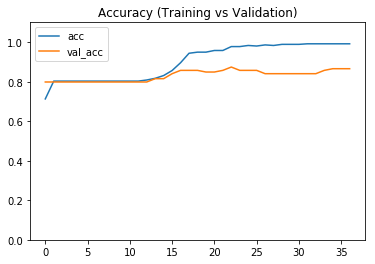

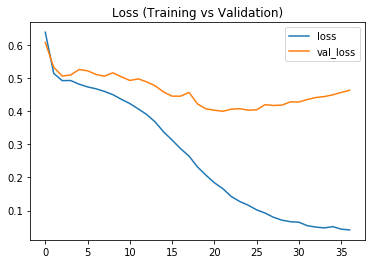

In [12]:
class_wt = compute_class_wt(files['y_train'])

result, best_model, best_hist_df = tuning_model(hyper_params, files['X_train'], files['y_train'], class_wt, files['X_val'], files['y_val'])

&emsp;&emsp; As a result the best model consists of <br>
&emsp; 1. Input layer: Embedding layer with input=2127, embedding dimension=359, output=100 <br>
&emsp; 2. Hidden layer: <br>
&emsp;&emsp;&emsp;&emsp;1 Dropout(0.5) <br>
&emsp;&emsp;&emsp;&emsp;1 convolution layer: 64 filters with 3 kernel <br>
&emsp;&emsp;&emsp;&emsp;1 global max pooling <br>
&emsp;&emsp;&emsp;&emsp;1 fully-connected layer with 10 nodes <br>
&emsp; 3. Output layer: 1 fully-connected layers with 1 nodes, Adam optimizer, and 0.0005 learning rate. <br>

&emsp;&emsp; According to the above graph, accuracy and loss of validation dataset conforms to those of training dataset over learning epochs. The average accuracy of training and validation are 99.44% and 86.55%, respectively. Whereas, the average loss of training and validation are 0.0445 and 0.4627, respectively.
<br>
&emsp;&emsp; However, during model learning, the loss of training dataset is decreasing more than those of validation, and the accuracy of training dataset is also higher than those of validation. It means that the model performs better on the training dataset compared to validation, so it could be overfitting to training dataset.

## __Model Performance Evaluation__

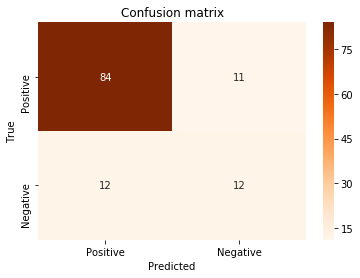

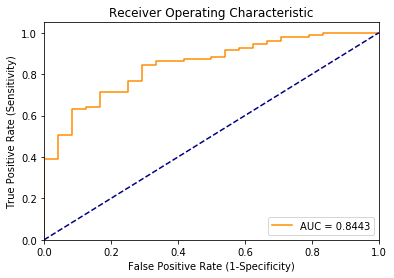

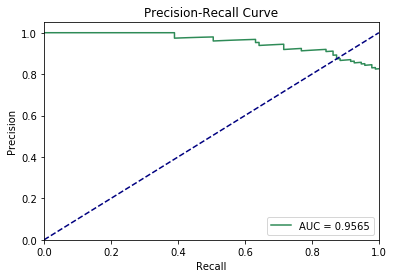

In [13]:
# Evaluate performance model by predict class of test dataset
y_pred = best_model.model.predict_classes(files['X_test'])
y_prob = best_model.model.predict_proba(files['X_test'])
confmat, fpr, tpr, auc, pr, recall, avg_precision = utils.evaluate_model(files['y_test'], y_pred, y_prob)

&emsp;&emsp; As a result of model evaluation, the area under the ROC curve and precision-recall curve are 0.8443 and 0.9565, respectively. It means that the model could accurately discriminate between positive and negative class with 84.43%. Also, the model has 95.65% to correctly predict the positive class.

## __Analysis on Error__

In [14]:
# Mapping word to X_test
word_feed = utils.word_decode(files['word_index'], files['X_test'])

In [15]:
# Merge data among raw data, preprocessed data, and predicted y
df_analyse = pd.DataFrame(np.concatenate((files['df_test'], 
                                          files['cleaned_test'].reshape(119,1),
                                          word_feed, y_pred), axis=1), 
                          columns=['comment_th','comment_eng','score','y_test','hospital','cleaned_text','word_feed','y_pred'])
df_analyse['y_pred'] = df_analyse['y_pred'].apply(lambda x: -1 if x==0 else x)
df_analyse['word_feed'] = df_analyse['word_feed'].apply(', '.join)
df_analyse['false_type'] = df_analyse.apply(lambda x: 'fp' if (x.y_pred > x.y_test) else ('fn' if x.y_pred < x.y_test else None), axis = 1)

# Focus on false prediction
df_analyse_false = df_analyse[(df_analyse['false_type'] == 'fp') | (df_analyse['false_type'] == 'fn')]
print('Number of false prediction\n{}'.format(df_analyse_false[['y_pred','false_type']].groupby('false_type').count()))
df_analyse_false

Number of false prediction
            y_pred
false_type        
fn          11    
fp          12    


,comment_th,comment_eng,score,y_test,hospital,cleaned_text,word_feed,y_pred,false_type
10,ชอบโรงบาลนี้มากคะถึงจะรอนานก็เค้าใจเพราะคนไข้เยอะและมีอย่างนึ่งอยากขอไม่ต้องให้คนเข้ามาเดินขายของนะคะพอรอไม่ซื้อก็ด่า วันนี้กผ้เหมือนกันไม่รู้เค้าด่าเราหรือป่าว ตอนเราลงบันได้เลื่อยลงมาเค้าก็ลงตามมาด้วย เค้าก็พูดกับเพื่อนเค้าข้างหลังเราว่า ซื้อดอกเดียวก็ไม่ได้ไอพวกเหี้ยขี้งก เพราะเค้าก็มาขอให้เราซื้อเหมือนกัน ขอละนะคะ,"I like this hospital very much. To wait for a long time, he is very patient because he has a lot of steaming things. Today, I don't know how to curse us. When we got down, he saw him down and followed him. He said to his friends behind us that Buy one flower, not a cough, bad guys Because he came to ask us to buy as well.",5,1,corpus_chula,like hospital much wait long time patient lot steaming things today know curse us got down saw followed him said friends behind us buy one flower cough bad guys came ask us buy well,"like, hospital, much, wait, long, time, patient, lot, things, today, know, us, got, saw, followed, him, said, friends, behind, us, buy, one, bad, guys, came, ask, us, buy, well",-1,fn
15,มีระบบการจองคิวที่ดีค่ะ พยาบาลจะคอยแนะนำ ในครั้งแรกที่ไปทำประวัติ และแนะนำให้ไปคลินิคธรรมดาหากไม่ต้องการเสียค่าพบหมอแพง และคุณหมอพูดดีมากๆค่ะ ใจดี การให้บริการระหว่างรอคิวดี แต่อาจจะต้องรอคิวนานหน่อยควรไปตั้งแต่ตีห้าครึ่งเพื่อที่จะได้รับคิวและเพื่อให้ทันในการพบหมอ และคุณพยาบาลที่ทำการเรียกคิวมีการแนะนำว่าหากไม่ต้องการรอคิวนาน ให้ไปทำเรื่องที่ห้องฉุกเฉิน สำหรับผู้ที่ไม่สบาย ปวดหัวตัวร้อน ที่ไม่ต้องการรอคิวนาน,"There is a good queue reservation system. Nurses will recommend The first time he made history And recommend to go to a regular clinic if you do not want to pay for the expensive doctor And the doctor said very well But may have to wait for a long time, should go from five and a half to get the queue and to keep up with the doctor And the nurse who calls the queue has suggested that if you don't want to wait for a long time To do the matter in the emergency room For those who are sick Headache and fever Who do not want to wait for a long time",4,1,corpus_chula,good queue reservation system nurses recommend first time made history recommend go regular clinic want pay expensive doctor doctor said well may wait long time go five half get queue keep doctor nurse calls queue suggested want wait long time matter emergency room sick headache fever want wait long time,"good, queue, reservation, system, nurses, recommend, first, time, made, history, recommend, go, regular, clinic, want, pay, expensive, doctor, doctor, said, well, may, wait, long, time, go, half, get, queue, keep, doctor, nurse, calls, queue, want, wait, long, time, matter, emergency, room, sick, fever, want, wait, long, time",-1,fn
20,ไปหาหมอเนื่องจากฮอร์โมนไม่ปกติ ตอนแรกคิดว่าศิริราชจะต้องรอนานมากๆเนื่องจากใช้สิทธิ์บัตรทองแต่ปรากฎคือเดี๋ยวนี้โรงพยาบาลพัฒนาระบบดีมากๆ รอไม่ถึงชั่วโมงได้พบคุณหมอและรับยาภายในสามสิบนาทีหลังตรวจเสร็จ คุณหมอเก่งและให้คำแนะนำอย่างดี พยาบาลและเจ้าหน้าที่ให้การบริการและความช่วยเหลืออย่างเป็นระบบ ดีมากๆค่า ตอนแรกคิดว่าไปรักษาบัตรทองจะต้องรอทั้งวันและเจอบริการไม่ดี ศิริราชสมัยนี้ลบล้างความเชื่อเก่าๆได้อย่างหมดจรดค่ะ,"Go to the doctor because of abnormal hormones At first I thought that Siriraj had to wait a long time because of the gold card rights, but it appears that now the hospital has developed a very good system. Wait for less than an hour to see a doctor and receive the medicine within thirty minutes after the examination is completed. Dr. Weng and give good advice Nurses and staff provide a very systematic and helpful service and assistance. At first, thinking of going to the gold card to wait for the whole day and encounter bad service. Siriraj nowadays has completely erased old beliefs.",5,1,corpus_siriraj,go doctor abnormal hormones first thought siriraj wait long time gold card rights appears hospital developed good system wait less hour see doctor receive medicine within thirty minutes examination completed dr weng give good ad

## False prediction could occur because of 3 main reasons.

### _1. Incorrect translation:_ The Google translator API could not translate some Thai words or incorrect translation leading to wrong interpreting.

In [16]:
df_analyse_false.loc[([94,117])]

,comment_th,comment_eng,score,y_test,hospital,cleaned_text,word_feed,y_pred,false_type
94,โรงพยาบาลจุฬาฯคือสุดยอดผู้เชี่ยวชาญในเรื่องโรคหัวใจ เด็กเล็กเด็กอ่อนแค่ไหนก็สามารถผ่าตัดช่วยได้ ขอบคุณที่ช่วยชีวิตลูกชาย ให้เราได้ลูกชายที่แข็งแรงกลับมา ขอบคุณจากใจค่ะ,"Chula Hospital is the ultimate expert in heart disease. Young children, little children can help with surgery. Thank you for saving your son's life. Let us have a strong son back. Thank you from your heart",5,1,corpus_chula,chula hospital ultimate expert heart disease young children little children help surgery thank saving sons life let us strong son back thank heart,"chula, hospital, expert, heart, disease, young, children, little, children, help, surgery, thank, life, let, us, strong, son, back, thank, heart",-1,fn
117,นานเกิ๊น,Nung Goan,1,-1,corpus_chula,nung goan,,1,fp


### _2. Ambiguous sentences:_ One comment contains both sides of positive and negative or the comment is not related to those hospital. Therefore, it could make the model confuse to predict the score.

In [17]:
df_analyse_false.loc[([10,20,42,89,109])]

,comment_th,comment_eng,score,y_test,hospital,cleaned_text,word_feed,y_pred,false_type
10,ชอบโรงบาลนี้มากคะถึงจะรอนานก็เค้าใจเพราะคนไข้เยอะและมีอย่างนึ่งอยากขอไม่ต้องให้คนเข้ามาเดินขายของนะคะพอรอไม่ซื้อก็ด่า วันนี้กผ้เหมือนกันไม่รู้เค้าด่าเราหรือป่าว ตอนเราลงบันได้เลื่อยลงมาเค้าก็ลงตามมาด้วย เค้าก็พูดกับเพื่อนเค้าข้างหลังเราว่า ซื้อดอกเดียวก็ไม่ได้ไอพวกเหี้ยขี้งก เพราะเค้าก็มาขอให้เราซื้อเหมือนกัน ขอละนะคะ,"I like this hospital very much. To wait for a long time, he is very patient because he has a lot of steaming things. Today, I don't know how to curse us. When we got down, he saw him down and followed him. He said to his friends behind us that Buy one flower, not a cough, bad guys Because he came to ask us to buy as well.",5,1,corpus_chula,like hospital much wait long time patient lot steaming things today know curse us got down saw followed him said friends behind us buy one flower cough bad guys came ask us buy well,"like, hospital, much, wait, long, time, patient, lot, things, today, know, us, got, saw, followed, him, said, friends, behind, us, buy, one, bad, guys, came, ask, us, buy, well",-1,fn
20,ไปหาหมอเนื่องจากฮอร์โมนไม่ปกติ ตอนแรกคิดว่าศิริราชจะต้องรอนานมากๆเนื่องจากใช้สิทธิ์บัตรทองแต่ปรากฎคือเดี๋ยวนี้โรงพยาบาลพัฒนาระบบดีมากๆ รอไม่ถึงชั่วโมงได้พบคุณหมอและรับยาภายในสามสิบนาทีหลังตรวจเสร็จ คุณหมอเก่งและให้คำแนะนำอย่างดี พยาบาลและเจ้าหน้าที่ให้การบริการและความช่วยเหลืออย่างเป็นระบบ ดีมากๆค่า ตอนแรกคิดว่าไปรักษาบัตรทองจะต้องรอทั้งวันและเจอบริการไม่ดี ศิริราชสมัยนี้ลบล้างความเชื่อเก่าๆได้อย่างหมดจรดค่ะ,"Go to the doctor because of abnormal hormones At first I thought that Siriraj had to wait a long time because of the gold card rights, but it appears that now the hospital has developed a very good system. Wait for less than an hour to see a doctor and receive the medicine within thirty minutes after the examination is completed. Dr. Weng and give good advice Nurses and staff provide a very systematic and helpful service and assistance. At first, thinking of going to the gold card to wait for the whole day and encounter bad service. Siriraj nowadays has completely erased old beliefs.",5,1,corpus_siriraj,go doctor abnormal hormones first thought siriraj wait long time gold card rights appears hospital developed good system wait less hour see doctor receive medicine within thirty minutes examination completed dr weng give good advice nurses staff provide systematic helpful service assistance first thinking going gold card wait whole day encounter bad service siriraj nowadays completely erased old beliefs,"go, doctor, first, thought, siriraj, wait, long, time, gold, card, rights, appears, hospital, developed, good, system, wait, less, hour, see, doctor, receive, medicine, within, minutes, examination, completed, dr, weng, give, good, advice, nurses, staff, provide, service, first, thinking, going, gold, card, wait, whole, day, bad, service, siriraj, completely, old",-1,fn
42,ดีครับรพ.ต่างจังหวัดแย่มากๆลูกสาวป่วยแต่อายุ9ขวบตอนนี้22แล้วไปกลับทุกๆ3เดือน,"Well, the provincial hospital is very bad. The daughter is sick but is 9 years old. Now 22 and go back every 3 months.",5,1,corpus_rama,well provincial hospital bad daughter sick 9 years old 22 go back every 3 months,"well, provincial, hospital, bad, daughter, sick, 9, years, old, 22, go, back, every, 3, months",-1,fn
89,ผู้ป่วยบางคน จะตายไม่ตายแลแต่หมอบอกว่าไม่เป็นอะไร ตรวจหาสาเหตุไม่เจอ ไปก็หลายโรงพยาบาลเสียเงินทองก็มากมาย ทุกที่หมอก็บอกว่าไม่เป็นอะไร ถ้าหมดที่ไปแล้วลองคุยกับหนูได้นะครับ,"Some patients will die and not die, but the doctor says nothing. Can't detect the cause Went to many hospitals and lost a lot of money Everywhere the doctor said that it was nothing. If you go out and try talking to me",4,1,corpus_chula,patients die die doctor says nothing detect cause went many hospitals lost lot money everywhere doctor said nothing go try talking,"patients, die, die, doctor, says, nothing, detect, cause, went, many, hospitals, lost, lot, money, everywhere, doctor, said, n

### _3 Score is not corresponding to comment_

In [18]:
df_analyse_false.loc[([68])]

,comment_th,comment_eng,score,y_test,hospital,cleaned_text,word_feed,y_pred,false_type
68,พยาบาลพูดจาไม่ค่อยจะดีเท่าไหร่ ไม่รุ้จักว่าใครคือคนที่จะเคารพหรือไม่ คนแก่ชราก้อด่าเค้าเกินไป,The nurse spoke very poorly. Do not know who is the person who will respect or not Old people scold him too,5,1,corpus_rama,nurse spoke poorly know person respect old people scold,"nurse, spoke, poorly, know, person, old, people",-1,fn


In [19]:
# Prepare predicted y for whole dataset (use for syntactic analysis)
y_pred_all = best_model.model.predict_classes(files['X'])
y_prob_all = best_model.model.predict_proba(files['X'])

# Save the predicted value into numpy array
utils.save_np(data_folder, {'y_pred_all':y_pred_all, 
                            'y_prob_all':y_prob_all})

## __Conclusion__

&emsp;&emsp; The optimum model for text classification consists of one embedding with 100 outputs, one of 0.5 dropout layer, 64 filters of one (1x3) convolution, one global max pooling, 10 nodes of one fully-connected, and end up with Adam optimzer using 0.0005 of learning rate. In addition, trending lines of accuracy and loss of validation dataset during learning are conformed to those training dataset, but the model might be overfitting to training datase compared to the validation dataset.
<br>
&emsp;&emsp; However, the result of model performance evaluation shows that the model can accurately discriminate between positive and negative class with 84.43%. It also has 95.65% to correctly predict the positive class. As a result of error analysis, there are 3 important problems caused false prediction such as incorrect translation, ambiguous sentences, and non-relational between comment and scoring.